In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
%matplotlib inline

In [10]:
# 如果是linux系统
trainPath = os.getcwd()+'/X_train_outlier.csv'
testPath = os.getcwd()+'/processed_testY.csv'
train_df = pd.read_csv(trainPath, index_col=0)
test_df = pd.read_csv(testPath, index_col=0)

In [11]:
X_test=test_df.copy()
X_train=train_df.copy()
y_train=X_train.pop('acc_now_delinq')

In [12]:
#合并训练、测试集
all_df = pd.concat((train_df, test_df), axis = 0)

X_train_all = all_df.copy()
y_train_all = X_train_all.pop('acc_now_delinq')
X_train_all = np.array(X_train_all)

In [13]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,f1_score, recall_score,precision_score,roc_auc_score
from xgboost import plot_importance,plot_tree


In [64]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
def ratio_multiplier(y):
    multiplier = {0: 0.05, 1: 1}
    target_stats = Counter(y)
    for key, value in target_stats.items():
        target_stats[key] = int(value * multiplier[key])
    return target_stats

In [65]:
rus = RandomUnderSampler(random_state=100,ratio=ratio_multiplier)#100


X_res, y_res = rus.fit_sample(X_train, y_train)

In [16]:
X_res.shape

(38515, 20)

### 0.准备工作

In [17]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

In [18]:
#定制f2score,偏向召回率
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# grid = GridSearchCV(LinearSVC(), param_grid={'C': [1, 10]}, scoring=ftwo_scorer)

In [19]:
#两种写法自定义 f2score
def f_beta_wrapper(y,t):
    t = t.get_label()
    y_bin = [1. if y_cont > 0.5 else 0. for y_cont in y] # binaryzing your output
    
    return 'f2',-fbeta_score(t,y_bin, beta=2)


from sklearn.metrics import confusion_matrix
def customedscore(preds, dtrain):
    label = dtrain.get_label()
    pred = [int(i>=0.5) for i in preds]
    confusion_matrixs = confusion_matrix(label, pred)
    recall =float(confusion_matrixs[0][0]) / float(confusion_matrixs[0][1]+confusion_matrixs[0][0])
    precision = float(confusion_matrixs[0][0]) / float(confusion_matrixs[1][0]+confusion_matrixs[0][0])
    F = -5*precision* recall/(4*precision+1*recall)*100
    return 'FSCORE',float(F)

### estimator估计器调优

In [20]:
def modelfit(model, X_train, y_train, useTrainCV=True, cv_folds=None, early_stopping_rounds=150):
    
    if useTrainCV:
        xgb_param = model.get_xgb_params()
        
        xgtrain = xgb.DMatrix(X_train, label = y_train)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], folds =cv_folds,
             feval = f_beta_wrapper, early_stopping_rounds=early_stopping_rounds)
        
        n_estimators = cvresult.shape[0]
        model.set_params(n_estimators = n_estimators)
        
        print (cvresult)
    
    
    #Fit the algorithm on the data
    model.fit(X_train, y_train, eval_metric=f_beta_wrapper)
    
    # Predict training set:
    predictions = model.predict( X_train )
    predprob = model.predict_proba( X_train )[:,1]
    
#     # Predict test set:
#     predictions_test = model.predict( X_test )
#     predprob_test = model.predict_proba( X_test )[:,1]  
    
    
    # Print model report:
    print ( "\nModel Report" )
    print ( "Accuracy (Train): %.4g" % accuracy_score(y_train, predictions) )
    print ( "Recall (Train): %.4g" % recall_score(y_train, predictions) )
    print ( "Precision (Train): %.4g" % precision_score(y_train, predictions) )
    print ( "F2score (Train): %.4g" % fbeta_score(y_train, predictions, beta=2) )
    print ( "AUC Score (Train): %f" % roc_auc_score(y_train, predprob) )
    
#     print ( "Accuracy (Test): %.4g" % accuracy_score(y_test, predictions) )
#     print ( "Recall (Test): %.4g" % recall_score(y_test, predictions) )
#     print ( "Precision (Test): %.4g" % precision_score(y_test, predictions) )
#     print ( "F2score (Test): %.4g" % fbeta_score(y_test, predictions, beta=2) )
#     print ( "AUC Score (Test): %f" % roc_auc_score(y_test, predprob) )
    
    plot_importance(model)
    

     test-error-mean  test-error-std  test-f2-mean  test-f2-std  \
0           0.696405        0.046123     -0.372178     0.012125   
1           0.694016        0.029756     -0.374864     0.008410   
2           0.681086        0.016829     -0.379686     0.004260   
3           0.654161        0.002818     -0.387166     0.001501   
4           0.656264        0.011622     -0.386234     0.002471   
5           0.653226        0.028681     -0.387926     0.008081   
6           0.645048        0.026678     -0.391601     0.008282   
7           0.644243        0.034731     -0.391533     0.010923   
8           0.632949        0.024435     -0.395626     0.007185   
9           0.621395        0.015514     -0.399377     0.004841   
10          0.619136        0.015981     -0.400867     0.004442   
11          0.609477        0.017565     -0.403898     0.005297   
12          0.598858        0.018003     -0.407672     0.005416   
13          0.595482        0.010704     -0.408856     0.00300

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy (Train): 0.7648
Recall (Train): 0.9985
Precision (Train): 0.2663
F2score (Train): 0.6443
AUC Score (Train): 0.966855


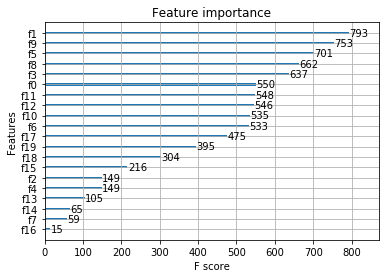

In [21]:
xgb0 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=50,
    max_delta_step = 7,
    seed=3)
modelfit(xgb0,X_res, y_res, cv_folds = kfold)

### scale_pos_weight=20 

In [23]:
#max_delta_step
#max_delta_step = np.arange(5,15,1)
#scale_pos_weight
scale_pos_weight = np.arange(4,35,2)
param_test1 = dict(scale_pos_weight=scale_pos_weight)
param_test1

{'scale_pos_weight': array([ 4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34])}

In [25]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=50,
    max_delta_step = 7,
    seed=3)

gsearch2 = GridSearchCV(xgb1, param_grid = param_test1, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch2.fit(X_res , y_res)
gsearch2.grid_scores_, gsearch2.best_params_,     gsearch2.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.49051, std: 0.01601, params: {'scale_pos_weight': 4},
  mean: 0.52507, std: 0.01786, params: {'scale_pos_weight': 6},
  mean: 0.53199, std: 0.01670, params: {'scale_pos_weight': 8},
  mean: 0.54500, std: 0.01390, params: {'scale_pos_weight': 10},
  mean: 0.54229, std: 0.02047, params: {'scale_pos_weight': 12},
  mean: 0.55402, std: 0.01847, params: {'scale_pos_weight': 14},
  mean: 0.55605, std: 0.01470, params: {'scale_pos_weight': 16},
  mean: 0.55287, std: 0.01437, params: {'scale_pos_weight': 18},
  mean: 0.54967, std: 0.00797, params: {'scale_pos_weight': 20},
  mean: 0.55633, std: 0.01466, params: {'scale_pos_weight': 22},
  mean: 0.55015, std: 0.01768, params: {'scale_pos_weight': 24},
  mean: 0.55071, std: 0.00991, params: {'scale_pos_weight': 26},
  mean: 0.54832, std: 0.00983, params: {'scale_pos_weight': 28},
  mean: 0.54913, std: 0.01214, params: {'scale_pos_weight': 30},
  mean: 0.54881, std: 0.01058, params: {'scale_pos_weight': 32},
  mean: 0.54454, std: 0.0114

### max_delta_step=1

In [26]:
#max_delta_step
max_delta_step = np.arange(1,15,1)
#scale_pos_weight
#scale_pos_weight = np.arange(10,35,2)
param_test2 = dict(max_delta_step=max_delta_step)
param_test2

{'max_delta_step': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}

In [27]:
xgb2 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 7,
    seed=3)

gsearch3 = GridSearchCV(xgb2, param_grid = param_test2, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch3.fit(X_res , y_res)
gsearch3.grid_scores_, gsearch3.best_params_,     gsearch3.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.55445, std: 0.01065, params: {'max_delta_step': 1},
  mean: 0.55702, std: 0.01115, params: {'max_delta_step': 2},
  mean: 0.55052, std: 0.01030, params: {'max_delta_step': 3},
  mean: 0.55347, std: 0.00796, params: {'max_delta_step': 4},
  mean: 0.55421, std: 0.01482, params: {'max_delta_step': 5},
  mean: 0.55543, std: 0.01540, params: {'max_delta_step': 6},
  mean: 0.55633, std: 0.01466, params: {'max_delta_step': 7},
  mean: 0.55633, std: 0.01521, params: {'max_delta_step': 8},
  mean: 0.55368, std: 0.01527, params: {'max_delta_step': 9},
  mean: 0.55535, std: 0.01439, params: {'max_delta_step': 10},
  mean: 0.55436, std: 0.01482, params: {'max_delta_step': 11},
  mean: 0.55436, std: 0.01482, params: {'max_delta_step': 12},
  mean: 0.55436, std: 0.01482, params: {'max_delta_step': 13},
  mean: 0.55436, std: 0.01482, params: {'max_delta_step': 14}],
 {'max_delta_step': 2},
 0.557015135550732)

In [28]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
#{'max_depth': 8, 'min_child_weight': 4},
# param_test3 = { 'gamma':[i/10.0 for i in range(0,5)] }
max_depth = np.arange(2,12,1)
# min_child_weight = np.arange(1,10,2)
param_test3 = dict(max_depth=max_depth)
param_test3

{'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11])}

In [29]:
xgb3 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    seed=3)


gsearch4 = GridSearchCV(xgb3, param_grid = param_test3, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch4.fit(X_res , y_res)
gsearch4.grid_scores_, gsearch4.best_params_,     gsearch4.best_score_


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.52720, std: 0.00482, params: {'max_depth': 2},
  mean: 0.54133, std: 0.00845, params: {'max_depth': 3},
  mean: 0.54782, std: 0.00959, params: {'max_depth': 4},
  mean: 0.55702, std: 0.01115, params: {'max_depth': 5},
  mean: 0.54550, std: 0.01344, params: {'max_depth': 6},
  mean: 0.51452, std: 0.01408, params: {'max_depth': 7},
  mean: 0.49119, std: 0.01189, params: {'max_depth': 8},
  mean: 0.47852, std: 0.01833, params: {'max_depth': 9},
  mean: 0.45493, std: 0.01671, params: {'max_depth': 10},
  mean: 0.44874, std: 0.01669, params: {'max_depth': 11}],
 {'max_depth': 5},
 0.557015135550732)

In [30]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
#{'max_depth': 8, 'min_child_weight': 4},
# param_test3 = { 'gamma':[i/10.0 for i in range(0,5)] }
#max_depth = np.arange(2,12,1)
min_child_weight = np.arange(1,10,1)
param_test4 = dict(min_child_weight=min_child_weight)
param_test4

{'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [31]:
xgb4 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    seed=3)


gsearch5 = GridSearchCV(xgb4, param_grid = param_test4, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch5.fit(X_res , y_res)
gsearch5.grid_scores_, gsearch5.best_params_,     gsearch5.best_score_


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.55702, std: 0.01115, params: {'min_child_weight': 1},
  mean: 0.55464, std: 0.01711, params: {'min_child_weight': 2},
  mean: 0.55119, std: 0.01126, params: {'min_child_weight': 3},
  mean: 0.55322, std: 0.01133, params: {'min_child_weight': 4},
  mean: 0.55466, std: 0.01234, params: {'min_child_weight': 5},
  mean: 0.55413, std: 0.01537, params: {'min_child_weight': 6},
  mean: 0.55363, std: 0.00852, params: {'min_child_weight': 7},
  mean: 0.55297, std: 0.01730, params: {'min_child_weight': 8},
  mean: 0.55217, std: 0.01089, params: {'min_child_weight': 9}],
 {'min_child_weight': 1},
 0.557015135550732)

### gamma=9.2

In [32]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
#{'max_depth': 8, 'min_child_weight': 4},
#gamma = [ 0.1,0.5, 1,5, 10,50,100]
gamma = np.arange(0,10,1)
#gamma = np.arange(9,11,0.1)
#max_depth = np.arange(2,12,1)
#min_child_weight = np.arange(1,10,1)
param_test5 = dict(gamma=gamma)
param_test5

{'gamma': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])}

In [33]:
xgb5 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    seed=3)


gsearch6 = GridSearchCV(xgb5, param_grid = param_test5, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch6.fit(X_res , y_res)
gsearch6.grid_scores_, gsearch6.best_params_,     gsearch6.best_score_


/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.55102, std: 0.01174, params: {'gamma': 0},
  mean: 0.55702, std: 0.01115, params: {'gamma': 1},
  mean: 0.54703, std: 0.01302, params: {'gamma': 2},
  mean: 0.55052, std: 0.01599, params: {'gamma': 3},
  mean: 0.55042, std: 0.00754, params: {'gamma': 4},
  mean: 0.54945, std: 0.01053, params: {'gamma': 5},
  mean: 0.55234, std: 0.00574, params: {'gamma': 6},
  mean: 0.54837, std: 0.01555, params: {'gamma': 7},
  mean: 0.55275, std: 0.00958, params: {'gamma': 8},
  mean: 0.55238, std: 0.01297, params: {'gamma': 9}],
 {'gamma': 1},
 0.557015135550732)

### subsample=0.3

In [34]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
subsample = [i/10.0 for i in range(1,8)]
#colsample_bytree = [i/10.0 for i in range(6,10)]
param_test6 = dict(subsample=subsample)
param_test6

{'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]}

In [35]:
xgb6 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.3,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    seed=3)


gsearch7 = GridSearchCV(xgb6, param_grid = param_test6, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch7.fit(X_res , y_res)
gsearch7.grid_scores_, gsearch7.best_params_,     gsearch7.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.53692, std: 0.01490, params: {'subsample': 0.1},
  mean: 0.55194, std: 0.01885, params: {'subsample': 0.2},
  mean: 0.55702, std: 0.01115, params: {'subsample': 0.3},
  mean: 0.55725, std: 0.01215, params: {'subsample': 0.4},
  mean: 0.54908, std: 0.01331, params: {'subsample': 0.5},
  mean: 0.54937, std: 0.00890, params: {'subsample': 0.6},
  mean: 0.55254, std: 0.01437, params: {'subsample': 0.7}],
 {'subsample': 0.4},
 0.5572454837597236)

### colsample_bytree=0.8

In [36]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
#subsample = [i/10.0 for i in range(1,8)]
colsample_bytree = [i/10.0 for i in range(1,10)]
param_test7 = dict(colsample_bytree=colsample_bytree)
param_test7

{'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

In [37]:
xgb7 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.4,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    seed=3)


gsearch8 = GridSearchCV(xgb7, param_grid = param_test7, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch8.fit(X_res , y_res)
gsearch8.grid_scores_, gsearch8.best_params_,     gsearch8.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.51573, std: 0.00847, params: {'colsample_bytree': 0.1},
  mean: 0.54614, std: 0.00799, params: {'colsample_bytree': 0.2},
  mean: 0.55497, std: 0.00921, params: {'colsample_bytree': 0.3},
  mean: 0.55111, std: 0.00963, params: {'colsample_bytree': 0.4},
  mean: 0.55330, std: 0.01003, params: {'colsample_bytree': 0.5},
  mean: 0.55070, std: 0.00933, params: {'colsample_bytree': 0.6},
  mean: 0.55082, std: 0.01241, params: {'colsample_bytree': 0.7},
  mean: 0.55725, std: 0.01215, params: {'colsample_bytree': 0.8},
  mean: 0.55358, std: 0.00878, params: {'colsample_bytree': 0.9}],
 {'colsample_bytree': 0.8},
 0.5572454837597236)

### reg_alpha=0

In [38]:
reg_alpha = [i/10.0 for i in range(20,60,2)] #default = 0, 测试0.1,1，1.5，2
param_test8 = dict(reg_alpha=reg_alpha)
param_test8

{'reg_alpha': [2.0,
  2.2,
  2.4,
  2.6,
  2.8,
  3.0,
  3.2,
  3.4,
  3.6,
  3.8,
  4.0,
  4.2,
  4.4,
  4.6,
  4.8,
  5.0,
  5.2,
  5.4,
  5.6,
  5.8]}

In [39]:
xgb8 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.4,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    seed=3)


gsearch9 = GridSearchCV(xgb8, param_grid = param_test8, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch9.fit(X_res , y_res)
gsearch9.grid_scores_, gsearch9.best_params_,     gsearch9.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.55082, std: 0.01575, params: {'reg_alpha': 2.0},
  mean: 0.55695, std: 0.01174, params: {'reg_alpha': 2.2},
  mean: 0.55177, std: 0.00881, params: {'reg_alpha': 2.4},
  mean: 0.55215, std: 0.01724, params: {'reg_alpha': 2.6},
  mean: 0.55478, std: 0.01371, params: {'reg_alpha': 2.8},
  mean: 0.55769, std: 0.01382, params: {'reg_alpha': 3.0},
  mean: 0.56124, std: 0.01394, params: {'reg_alpha': 3.2},
  mean: 0.56218, std: 0.00858, params: {'reg_alpha': 3.4},
  mean: 0.54908, std: 0.00913, params: {'reg_alpha': 3.6},
  mean: 0.55395, std: 0.01312, params: {'reg_alpha': 3.8},
  mean: 0.56066, std: 0.01226, params: {'reg_alpha': 4.0},
  mean: 0.55653, std: 0.01155, params: {'reg_alpha': 4.2},
  mean: 0.55111, std: 0.01163, params: {'reg_alpha': 4.4},
  mean: 0.55627, std: 0.01048, params: {'reg_alpha': 4.6},
  mean: 0.55667, std: 0.01148, params: {'reg_alpha': 4.8},
  mean: 0.55741, std: 0.01433, params: {'reg_alpha': 5.0},
  mean: 0.55436, std: 0.01485, params: {'reg_alpha': 5.2

In [ ]:
### reg_lambda

In [41]:
reg_lambda = np.arange(0.2,4,0.2)     #default = 1，测试0.1， 0.5， 1，2
param_test9 = dict(reg_lambda=reg_lambda)
param_test9

{'reg_lambda': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6,
        2.8, 3. , 3.2, 3.4, 3.6, 3.8])}

In [42]:
xgb9 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.4,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    reg_alpha = 3.4,
    seed=3)


gsearch10 = GridSearchCV(xgb9, param_grid = param_test9, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch10.fit(X_res , y_res)
gsearch10.grid_scores_, gsearch10.best_params_,     gsearch10.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

([mean: 0.55594, std: 0.01304, params: {'reg_lambda': 0.2},
  mean: 0.55621, std: 0.01336, params: {'reg_lambda': 0.4},
  mean: 0.55588, std: 0.01507, params: {'reg_lambda': 0.6000000000000001},
  mean: 0.55674, std: 0.01596, params: {'reg_lambda': 0.8},
  mean: 0.56218, std: 0.00858, params: {'reg_lambda': 1.0},
  mean: 0.56028, std: 0.01001, params: {'reg_lambda': 1.2},
  mean: 0.55858, std: 0.01586, params: {'reg_lambda': 1.4000000000000001},
  mean: 0.55537, std: 0.01412, params: {'reg_lambda': 1.6},
  mean: 0.55828, std: 0.01037, params: {'reg_lambda': 1.8},
  mean: 0.55626, std: 0.01700, params: {'reg_lambda': 2.0},
  mean: 0.55505, std: 0.01541, params: {'reg_lambda': 2.2},
  mean: 0.55612, std: 0.00994, params: {'reg_lambda': 2.4000000000000004},
  mean: 0.55966, std: 0.00684, params: {'reg_lambda': 2.6000000000000005},
  mean: 0.55609, std: 0.00908, params: {'reg_lambda': 2.8000000000000003},
  mean: 0.55518, std: 0.01484, params: {'reg_lambda': 3.0000000000000004},
  mean: 0.

In [43]:
xgb10 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=358,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.4,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    reg_alpha = 3.4,
    reg_lambda=1.0,
    seed=3)


In [44]:
### learning_rate=0.05

In [45]:
learning_rate = [i/1000.0 for i in range(5,20,2)]   #default = 1，测试0.1， 0.5， 1，2
param_test10 = dict(learning_rate=learning_rate)
param_test10

{'learning_rate': [0.005, 0.007, 0.009, 0.011, 0.013, 0.015, 0.017, 0.019]}

In [46]:
xgb10 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=5000,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.4,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    reg_alpha = 3.4,
    reg_lambda=1.0,
    seed=3)


gsearch11 = GridSearchCV(xgb10, param_grid = param_test10, scoring=ftwo_scorer,n_jobs=-1, cv=kfold)
gsearch11.fit(X_res , y_res)

gsearch11.grid_scores_, gsearch11.best_params_,     gsearch11.best_score_

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/root/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, b

KeyboardInterrupt: 

In [88]:
xgb11 = XGBClassifier(
    learning_rate =0.01,
    n_estimators=12000,
    max_depth=5,
    min_child_weight=1,
    gamma=1,
    subsample=0.4,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    scale_pos_weight=22,
    max_delta_step = 2,
    reg_alpha = 3.4,
    reg_lambda=1.0,
    seed=3)


In [ ]:
xgb11.fit(X_res, y_res)

In [91]:
train_preds = xgb11.predict_proba(X_test.values)
train_predictions = [round(value[1] - 0.45) for value in train_preds] #控制这个threshold来提高f2值


In [ ]:
result=pd.Series(train_predictions,index=index)

In [ ]:
result=result.astype(int)

In [ ]:
result.to_csv("result2.csv",encoding='utf-8')